In [128]:
import json
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import pickle
from torchvision import transforms
from tqdm import tqdm
from training.patch import get_patches

import dnnlib
from calibration.ece import ECE

from data.classes import CIFAR10_CLASSES
from calibration.ReliabilityDiagram import ReliabilityDiagram

In [129]:
def flatten_metrics(json_obj: Dict) -> Dict:
    """Flatten nested metrics structure into a single level dictionary."""
    flattened = {}

    for key, value in json_obj.items():
        # Skip the num/std fields and only keep the mean values
        if isinstance(value, dict) and "mean" in value:
            flattened[key] = value["mean"]
        else:
            flattened[key] = value

    return flattened


def parse_metrics_file(file_path: str) -> pd.DataFrame:
    """Parse metrics file where each line is a JSON object into a DataFrame."""
    # Read the file line by line and parse each JSON object
    records = []
    with open(file_path, "r") as f:
        for line in f:
            try:
                json_obj = json.loads(line.strip())
                flattened = flatten_metrics(json_obj)
                records.append(flattened)
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")
                continue

    # Convert to DataFrame
    df = pd.DataFrame(records)

    # Convert timestamp to datetime
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

    return df

In [130]:
run_name = "training-runs/00080-train-cond-gpus2-batch128"
run_name = "training-runs/00081-run"
run_name = "training-runs/00101-run"
df = parse_metrics_file(f"{run_name}/stats.jsonl")

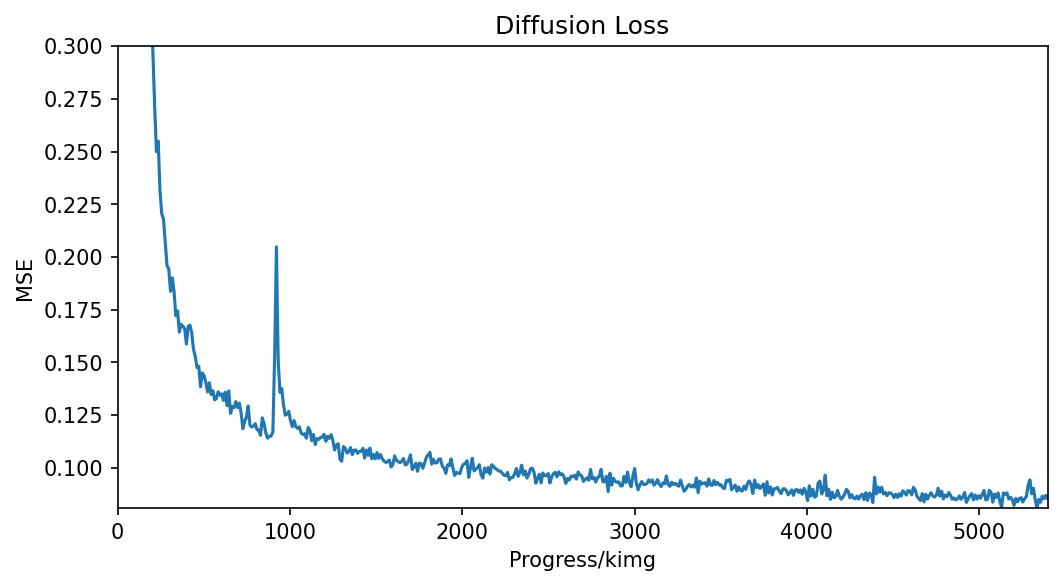

In [131]:
# create plot of progress/kimg
plt.figure(figsize=(8, 4), dpi=150)

plt.ylim(df["train/loss"].min(), 0.3)
plt.xlim(0, df["Progress/kimg"].max())
plt.title("Diffusion Loss")
plt.xlabel("Progress/kimg")
plt.ylabel("MSE")
plt.plot(df["Progress/kimg"], df["train/loss"])

plt.show()

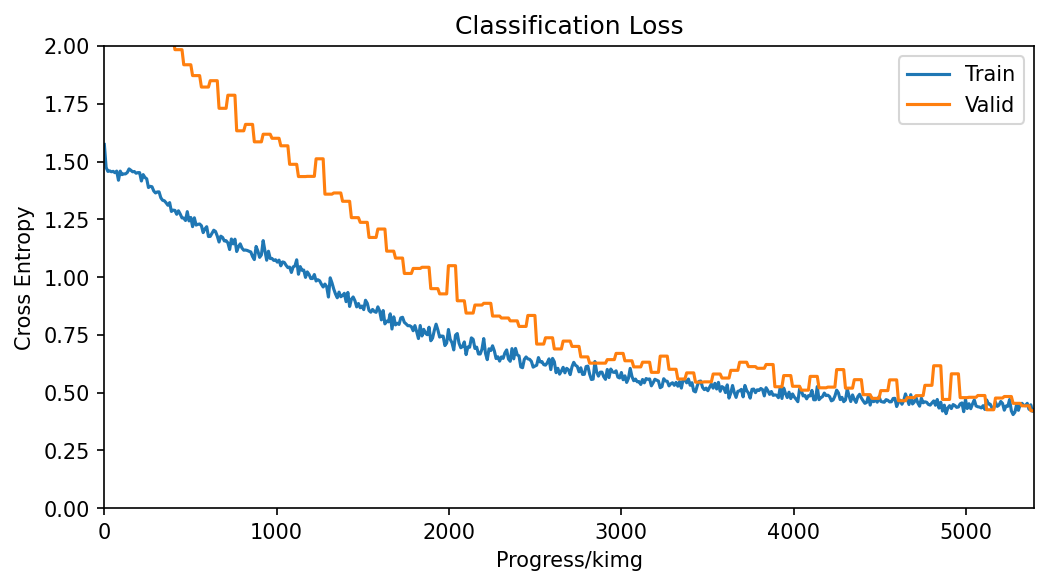

In [132]:
# create plot of progress/kimg
plt.figure(figsize=(8, 4), dpi=150)

plt.xlim(0, df["Progress/kimg"].max())
plt.ylim(0, 2)
plt.title("Classification Loss")
plt.xlabel("Progress/kimg")
plt.ylabel("Cross Entropy")
plt.plot(df["Progress/kimg"], df["train/cls_loss"], label="Train")
plt.plot(df["Progress/kimg"], df["val/cls_loss"], label="Valid")

plt.legend()
plt.show()

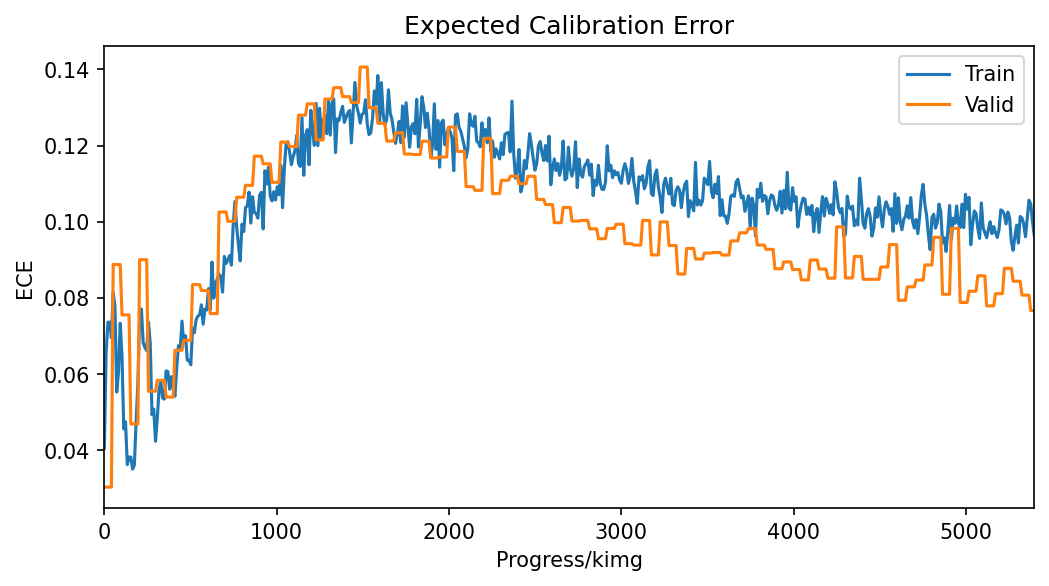

In [133]:
plt.figure(figsize=(8, 4), dpi=150)

plt.xlim(0, df["Progress/kimg"].max())
plt.title("Expected Calibration Error")
plt.xlabel("Progress/kimg")
plt.ylabel("ECE")
plt.plot(df["Progress/kimg"], df["train/cls_ece"], label="Train")
plt.plot(df["Progress/kimg"], df["val/cls_ece"], label="Valid")
plt.legend()

plt.show()

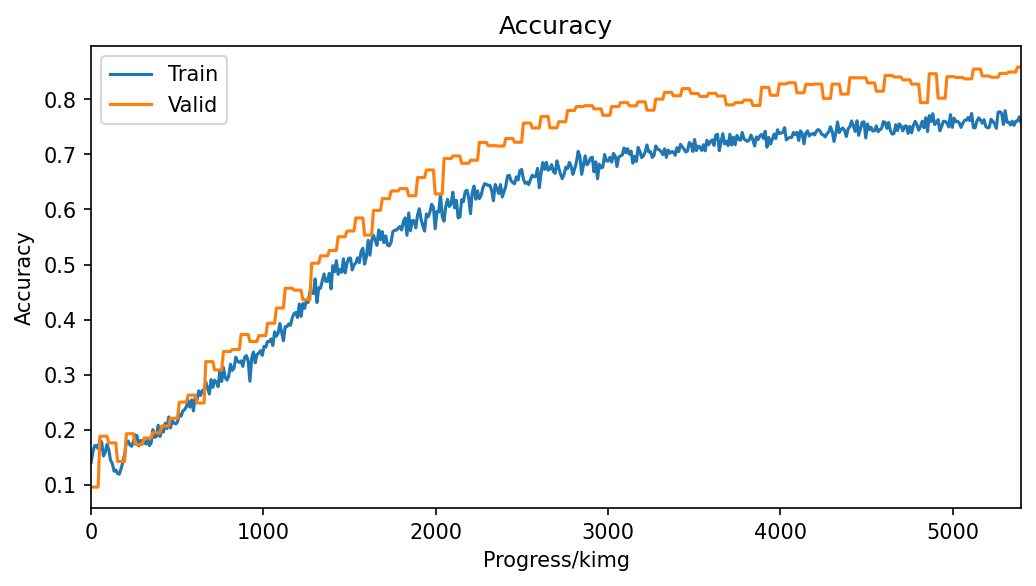

In [134]:
plt.figure(figsize=(8, 4), dpi=150)

plt.xlim(0, df["Progress/kimg"].max())
plt.title("Accuracy")
plt.xlabel("Progress/kimg")
plt.ylabel("Accuracy")
plt.plot(df["Progress/kimg"], df["train/cls_acc"], label="Train")
plt.plot(df["Progress/kimg"], df["val/cls_acc"], label="Valid")
plt.legend()

plt.show()

In [135]:
network_pkl = "./training-runs/00101-run/network-snapshot-004608.pkl"
test_dir = "./data/cifar10/test"
device = torch.device("cuda")
# Load the model.
with open(network_pkl, "rb") as f:
    net = pickle.load(f)["ema"].to(device)

c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=test_dir,
    use_labels=True,
)
c.dataloader_kwargs = dnnlib.EasyDict(batch_size=128, num_workers=4)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)
test_dataset_obj = dnnlib.util.construct_class_by_name(
    **c.dataset_kwargs, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(test_dataset_obj, **c.dataloader_kwargs)

In [148]:
def evaluate(net, dataloader, device, return_gts_and_confs=False):
    net.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    total_ece = 0  # Accumulate ECE across batches

    all_gts, all_confs, all_preds = [], [], []

    criterion = torch.nn.CrossEntropyLoss(reduction="sum")
    ece_criterion = ECE()

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to the device
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)
            total_samples += batch_size

            # Prepare input for the model
            patches, x_pos = get_patches(images, images.shape[-1])
            logits = net(
                torch.cat((patches, x_pos), dim=1),
                torch.zeros(batch_size, dtype=torch.long, device=device),
                class_labels=labels,
                cls_mode=True,
            )

            # Compute loss
            labels = labels.argmax(dim=1)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute probabilities and one-hot encoded confidences
            probs = torch.nn.functional.softmax(logits, dim=1)
            conf, pred = probs.max(dim=1)

            # Create one-hot encoded confidences
            conf_one_hot = torch.zeros_like(probs).scatter_(
                1, pred.unsqueeze(1), conf.unsqueeze(1)
            )

            # Update metrics
            total_correct += (pred == labels).sum().item()
            total_ece += ece_criterion.measure(
                probs.cpu().numpy(), labels.cpu().numpy()
            )

            if return_gts_and_confs:
                all_gts.append(labels.cpu())
                all_confs.append(conf_one_hot.cpu())
                all_preds.append(pred.cpu())

    # Calculate final metrics
    mean_loss = total_loss / total_samples
    mean_acc = total_correct / total_samples
    mean_ece = total_ece / len(dataloader)  # Average ECE across batches

    if return_gts_and_confs:
        return (
            mean_loss,
            mean_acc,
            mean_ece,
            np.concatenate(all_gts),
            np.concatenate(all_confs),
            np.concatenate(all_preds),
        )
    return mean_loss, mean_acc, mean_ece


In [149]:
test_loss, test_acc, test_ece, gts, confs, preds = evaluate(
    net=net,
    dataloader=test_dataloader,
    device=device,
    return_gts_and_confs=True,
)

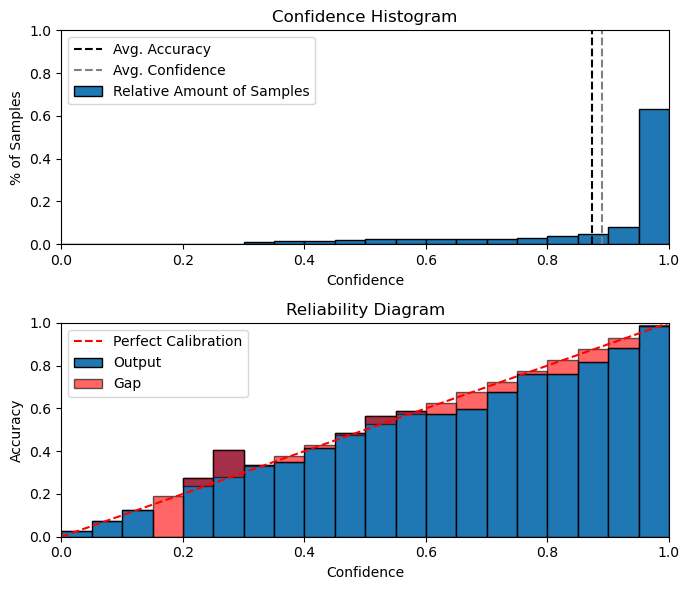

In [150]:
diagram = ReliabilityDiagram(bins=20)
diagram.plot(confs, gts)
plt.show()

In [151]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ECE: {test_ece:.4f}")

Test Loss: 0.3789
Test Accuracy: 0.8741
Test ECE: 0.0583


In [152]:
images, labels = [], []
for i, (image, label) in enumerate(test_dataloader):
    images.append(image)
    labels.append(label)

images = torch.cat(images)
labels = torch.cat(labels).argmax(dim=1).cpu().numpy()

In [ ]:
def plot_predictions(images, gts, confs, preds, num_samples=16):
    """ Plot random samples from the dataset with predictions and confidences.
    
    :param images: Tensor of shape (N, C, H, W) containing images.
    :param gts: Tensor of shape (N,) containing ground truth labels.
    :param confs: Tensor of shape (N, C) containing confidences.
    :param preds: Tensor of shape (N,) containing predicted labels.
    :param num_samples: Number of samples to plot. Default is 16.
    """
    # Randomly choose num_sample indices from images, gts, preds, and confs
    indices = np.random.choice(len(images), num_samples, replace=False)
    images = images[indices]
    gts = gts[indices]
    preds = preds[indices]
    confs = confs[indices].max(axis=1)

    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), dpi=150)
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)

        pred_name = CIFAR10_CLASSES[preds[i]]
        true_name = CIFAR10_CLASSES[gts[i]]

        # Add color to title based on correctness
        color = "green" if preds[i] == gts[i] else "red"

        ax.imshow(img)
        ax.set_title(
            f"Pred: {pred_name}\nTrue: {true_name}\nConf: {confs[i]:.2f}",
            color=color,
        )
        ax.axis("off")

    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

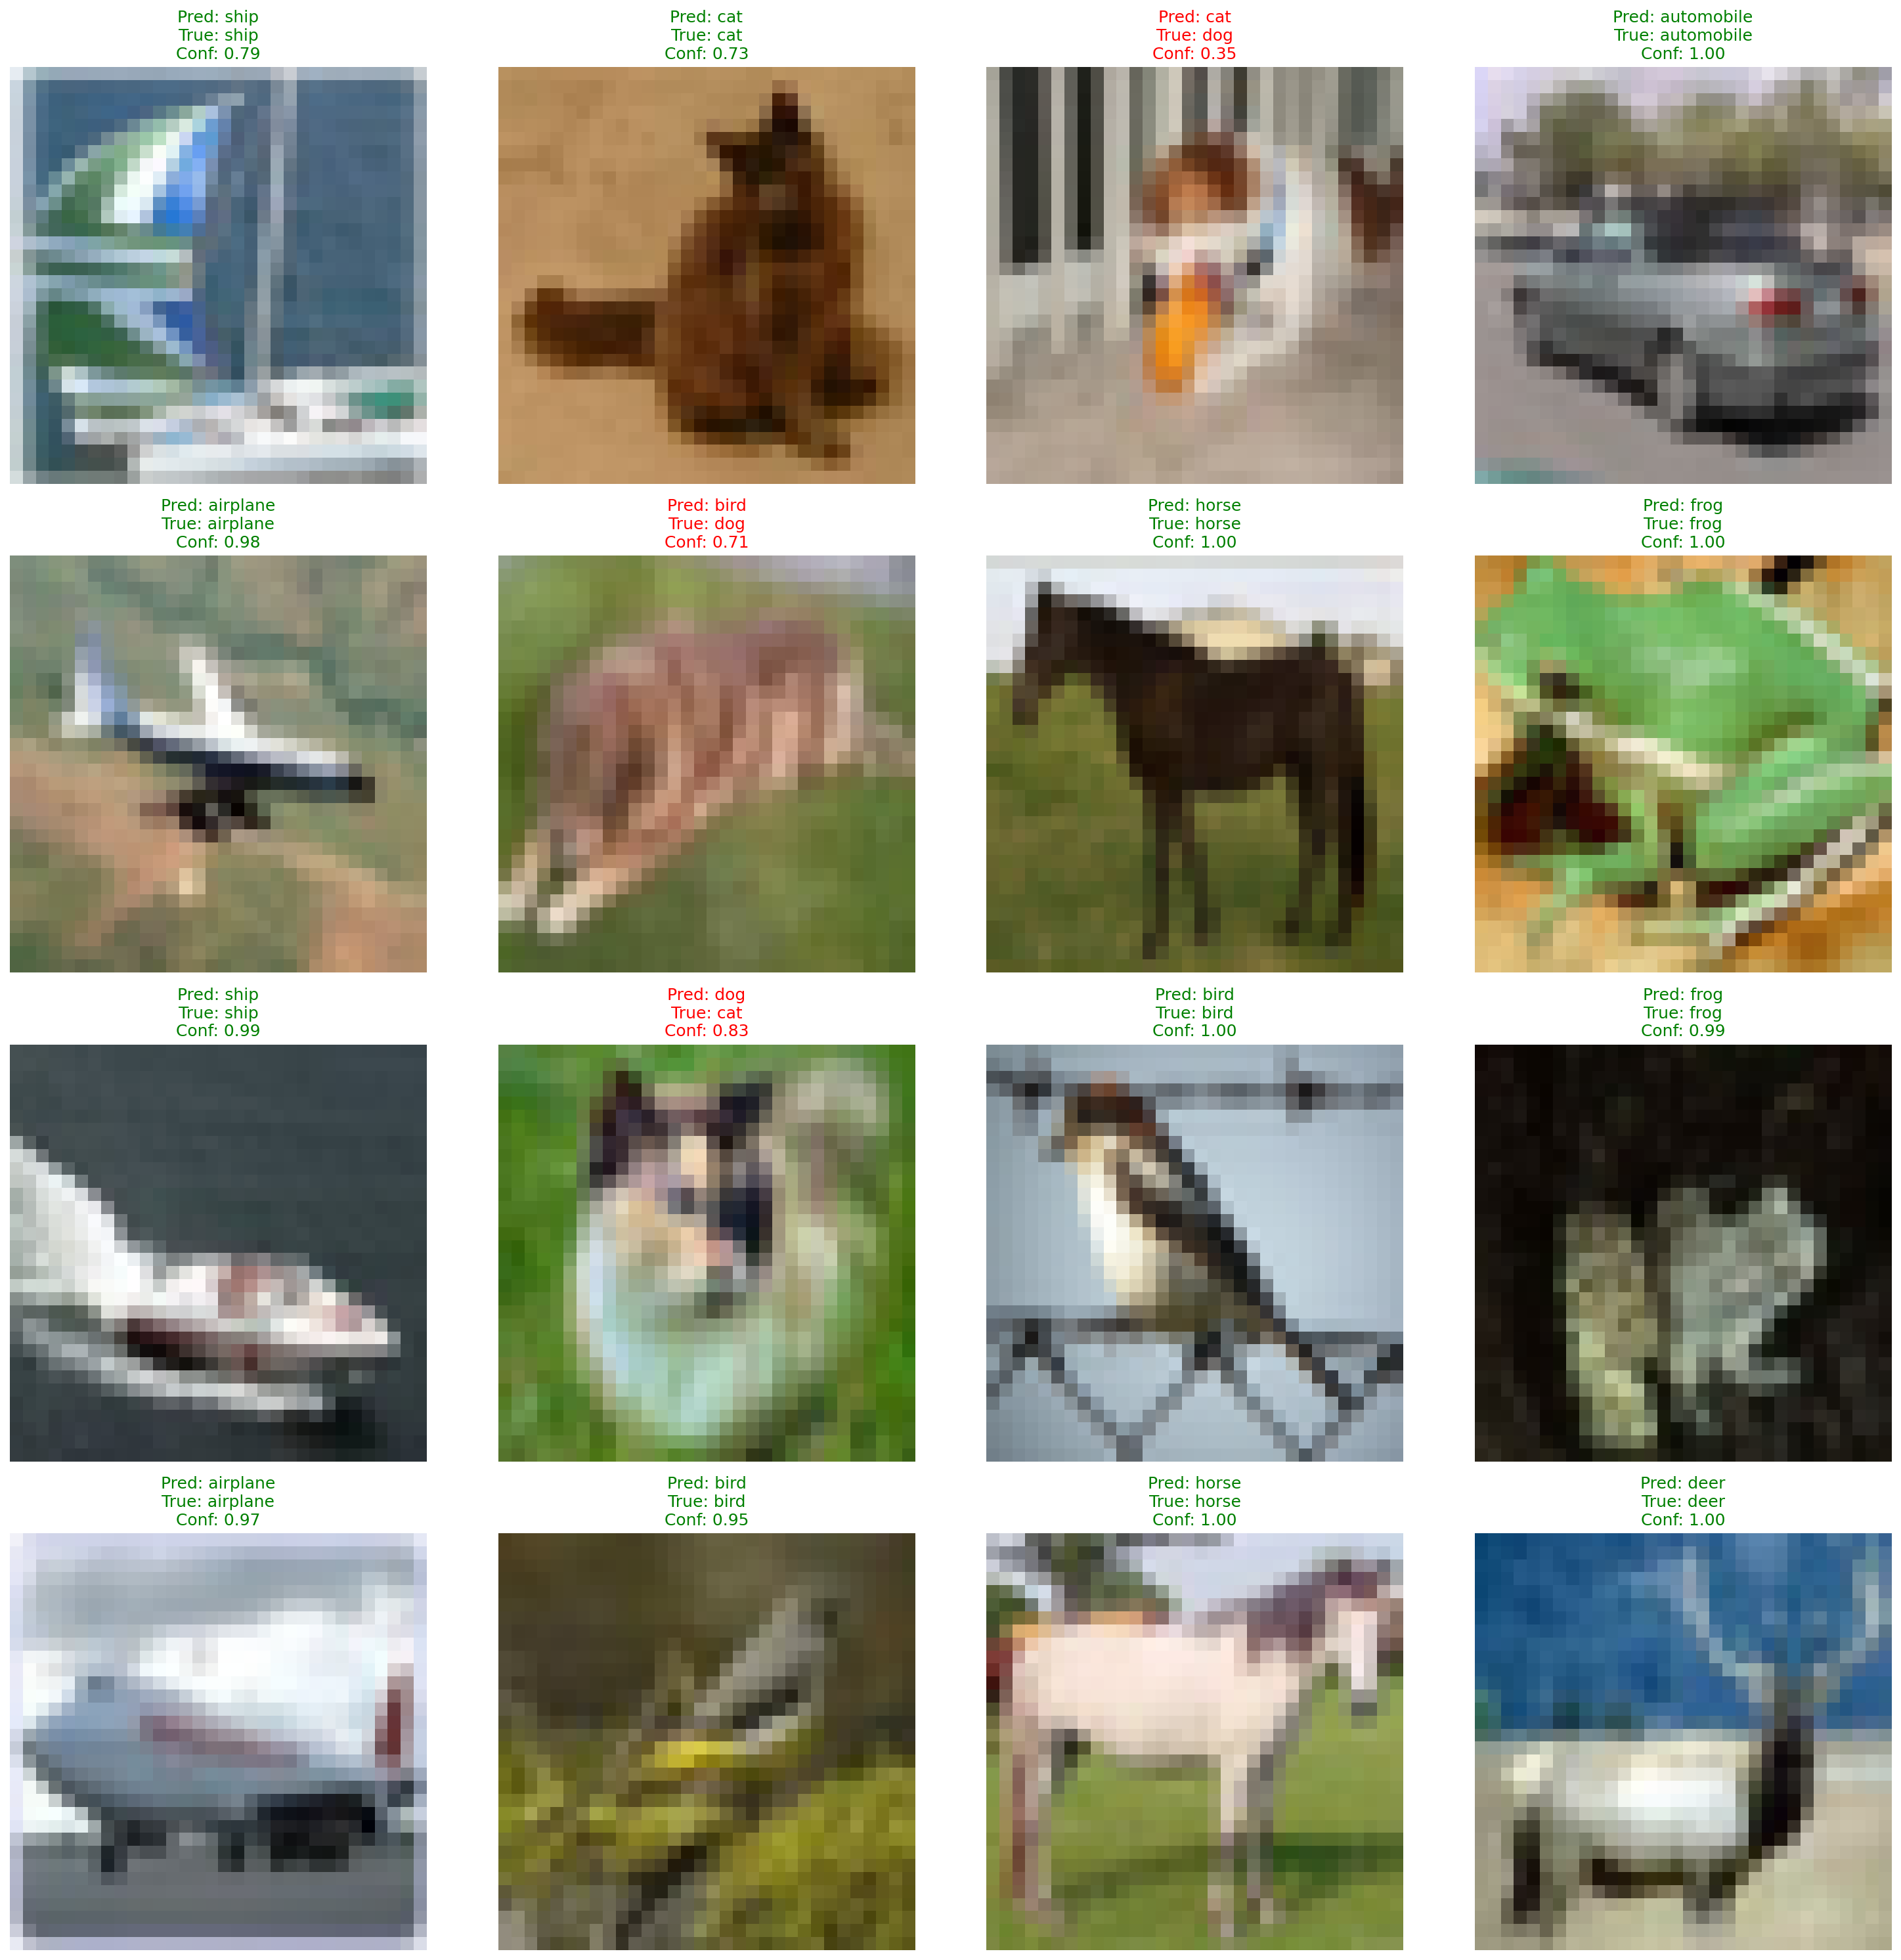

In [ ]:
plot_predictions(images, labels, confs, preds)